<a href="https://colab.research.google.com/github/A-Grossmann/Infant_Sleep_Analysis/blob/main/baby_sleep_prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# Import Data from the sleeping times and duration data

import pandas as pd
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import datetime as dt
from datetime import timedelta
from sklearn.cluster import MeanShift
import seaborn as sns
import matplotlib.cm as cm
from matplotlib.patches import FancyBboxPatch
import matplotlib as mpl
import datetime
import pytz


'''
  The first section is meant for combining, processing, and formating data, exploritory data analysis,
feature engineering making rolling 3 hr feeding windows and discreate measurment variables to classify measurments.

  This cell can be run once to create the cvs file for the cleaned data to be used for the animation of the graph.

'''

#designate name of person for file:
name = "Margot"

#Create Generalized file strings:
sleep_csv = f"{name}_sleep.csv"
growth_csv = f"{name}_growth.csv"
expressed_csv = f"{name}_expressed.csv"
formula_csv = f"{name}_formula.csv"
diaper_csv = f"{name}_diaper.csv"
pump_csv = "pump.csv"

#Import the Data for the size

df_sleep = pd.read_csv(sleep_csv)

df_size = pd.read_csv(growth_csv)

df_expressed = pd.read_csv(expressed_csv)

df_formula = pd.read_csv(formula_csv)

df_diaper = pd.read_csv(diaper_csv)

df_pump = pd.read_csv(pump_csv)

#Transform df time column into datetime
df_sleep['Time'] = pd.to_datetime(df_sleep['Time'], format='%m/%d/%y, %I:%M %p')
df_size['Time'] = pd.to_datetime(df_size['Time'], format='%m/%d/%y, %I:%M %p')
df_expressed['Time'] = pd.to_datetime(df_expressed['Time'], format='%m/%d/%y, %I:%M %p')
df_formula['Time'] = pd.to_datetime(df_formula['Time'], format='%m/%d/%y, %I:%M %p')
df_diaper['Time'] = pd.to_datetime(df_diaper['Time'], format='%m/%d/%y, %I:%M %p')
df_pump['Time'] = pd.to_datetime(df_pump['Time'], format='%m/%d/%y, %I:%M %p')

#Merge data sets for sleeping and growth
csvs_combined = pd.concat([df_sleep, df_size, df_expressed, df_formula, df_diaper, df_pump], join = 'outer', ignore_index=True)

# Sort by time column and reset index
csvs_combined = csvs_combined.sort_values('Time').reset_index(drop=True)

def fill_nan_with_last_value(df, col):
    """
  Replaces NaN values in a DataFrame with the last valid value in each column.
  """
    df[col] = df[col].ffill()

    return df

fill_nan_with_last_value(csvs_combined, 'Weight (lbs.)')


#Sum the total amount and fill it in for columns with a duration value
def sum_last_values_for_nan_fill(df,col_1,col_2, col_3):
    df.fillna({col_2: 0}, inplace=True)
    df.fillna({col_1: 0}, inplace=True)
    df["temp_fill"] = 0
    df[col_3] = 0
    for i in df.index.tolist():
        if df.iloc[i][col_1]== 0:
            a = df.iloc[i-1][col_2]
            b = df.iloc[i-1]["temp_fill"]
            c = a + b
            df.loc[i, "temp_fill"] = c
        else:
            df.loc[i, col_3] = df.iloc[i-1]['temp_fill']
    del df['temp_fill']
    return df

csvs_combined = sum_last_values_for_nan_fill(csvs_combined,'Duration(minutes)','Amount (ml)', 'Since_nap (ml)')

def datetime_index(df, time):

    # Convert the column to datetime, coercing errors to NaT
    df[time] = pd.to_datetime(df[time], errors='coerce')

    # Drop rows with NaT values (invalid dates)
    df = df.dropna(subset = [time])

    # Set 'datetime' as index
    df.set_index(time, inplace=True)

    return df


csvs_combined = datetime_index(csvs_combined, "Time")

def rolling_sums(df, time, amount, weight, increments, rate):

    for i in increments:
        r = f"Rolling_{i}_hr_feed"
        w = f"{i}h"
        p = f"{i}hr_projected_feed"
        pm = f"plus_minus_{i}hr_rolling"

        #Calculate rolling sum
        df[r] = df[amount].rolling(window = w).sum()

        #make a projected feed amount column
        df[p] = df[weight] * (i/24) * rate

        #make an plus/minus column
        df[pm] = df[r] - df[p]

    return df

csvs_combined_new_par = rolling_sums(csvs_combined, "Time", 'Weight (lbs.)', 'Amount (ml)', [24, 12, 3], 72)
csvs_combined.head()

#Turn the index into a Time column
csvs_combined_new_par['Time'] = csvs_combined_new_par.index

csvs_combined_new_par.reset_index(drop = True)


def wake_window(df, duration, time):
    df = df.reset_index(drop = True)
    df = df.sort_values(time)
    df['awake_window(minutes)'] = 0
    #NOTE: in this function Time must be a coluumn of the dataframe and not an index


    #remove all zero values for durration
    df_not = df[(df[duration] == 0)]
    df = df[df[duration] !=0]

    #fill in awake windo column with minutes awake
    df['awake_window(minutes)'] = df.loc[:, time].diff().dt.total_seconds() / 60

    #rejoin the dataframe with the original and sort by time

    df = pd.concat([df, df_not])
    df = df.sort_values(time)
    return df

#time of day evening afternoon morning

csvs_combined_new_par = wake_window(csvs_combined_new_par, 'Duration(minutes)', 'Time')


#make a time of day catagorical variable where evening 18 - 24, Night 0 - 6, Morning 6 - 12, Afternoon 12 - 18
def categorize_time(time):
  if time.hour >= 5 and time.hour < 12:
    return 'Morning'
  elif time.hour >= 12 and time.hour < 17:
    return 'Afternoon'
  elif time.hour >= 17 and time.hour < 22:
    return 'Evening'
  else:
    return 'Night'

# Create the new categorical column
csvs_combined_new_par['time_of_day'] = csvs_combined_new_par['Time'].apply(categorize_time)
#csvs_combined_new_par.head()

#Insert measurment hot code: sleep, feed, diaper, pump

def classify_measurment(df, var, col_1, col_2, col_3, col_4):
    for i in df.index.tolist():
        if df.loc[i, col_1] !=0:
            df.loc[i, 'measurment'] = var[0]
        elif df.loc[i, col_2] !=0:
            df.loc[i, 'measurment'] = var[1]
        elif pd.isnull(df.at[i, col_3]) == False:
            df.loc[i, 'measurment'] = var[2]
        elif pd.isna(df.at[i, col_4]) == False:
            df.loc[i, 'measurment'] = var[3]
        else:
            df.loc[i, 'measurment'] = 0

    return df

var = ['sleep', 'feed', 'diaper', 'pump']

csvs_combined_new_par = classify_measurment(csvs_combined_new_par, var, 'Duration(minutes)', 'Amount (ml)', 'Status', 'Total amount (ml)')

csvs_combined_new_par.head()

#Reorder
csvs_combined_new_par = csvs_combined_new_par[['Time', 'measurment', 'Duration(minutes)', 'awake_window(minutes)', 'time_of_day', 'Weight (lbs.)', 'Since_nap (ml)', 'Rolling_24_hr_feed', '24hr_projected_feed', 'plus_minus_24hr_rolling', 'Rolling_12_hr_feed', '12hr_projected_feed', 'plus_minus_12hr_rolling', 'Rolling_3_hr_feed', '3hr_projected_feed', 'plus_minus_3hr_rolling', 'Amount (ml)', 'Status','Total amount (ml)', 'Total Duration (min)' ]]

# Specify the file path and name
file_path = f"{name}_cleaned.csv"


# Export the DataFrame to the CSV file
#csvs_combined_new_par.to_csv(file_path, index=False)
csvs_combined_new_par.to_csv(file_path, index=False)


<ipython-input-3-9c3cafb2a87d>:188: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise in a future error of pandas. Value 'diaper' has dtype incompatible with float64, please explicitly cast to a compatible dtype first.
  df.loc[i, 'measurment'] = var[2]


In [ ]:
'''
Create a copy of cleaned file to run for modeling
'''

#Create copy for project
cleaned_df_dld = pd.read_csv(file_path, index_col = False).copy()
cleaned_df_dld['Time'] = pd.to_datetime(cleaned_df_dld['Time'], format='%Y-%m-%d %H:%M:%S')



In [ ]:
'''
This next section is to process and weight data so that the most relevent data for clustering is current
'''

#Only Looking at Sleep Measurements
sleep_df = cleaned_df_dld[cleaned_df_dld['measurment'] =='sleep'].reset_index(drop = True)


#Only looking at dates from now to a certain time period 20 days in the past

def filter_from_date(df, time_col, date, delta_date):

    #This filters out all past dates from designated date with a delta

    for index in df.index:
        dif = date - df.loc[index][time_col]
        dif = dif.days
        if dif > delta_date:
            df = df.drop(index)
        else:
            pass

date = sleep_df.iloc[-1]['Time']
filter_from_date(sleep_df, 'Time', date, 20)


#Make a special algorythm that weights the first date delta_days times more than the date 20 days ago
#by replicating the points
def weight_col(df, col, linear_weight=True):
    #This creates a weighted column with a distribution of another column
    if linear_weight == True:
        df.insert(1, 'mult_counter', float(0))
        t = max(df[col]) - min(df[col])
        t = t.days
        for index in df.index:
            dif = df.loc[index][col]- min(df[col])
            dif = dif.days
            mul = dif/(t/2)
            df.loc[index,'mult_counter'] = mul

    else:
        print("Choose a different weighting technique.")

    return df

sleep_df = weight_col(sleep_df, 'Time')

sleep_df.head()



df_resampled = sleep_df.copy()

# Extract the hour and minute from the index
df_resampled['Hour'] = sleep_df['Time'].dt.hour
df_resampled['Minute'] = sleep_df['Time'].dt.minute

# Create a new index representing the 15-minute intervals
df_resampled.index = df_resampled['Hour'] * 4 + df_resampled['Minute'] // 15

# Convert the integer values to timedeltas
df_resampled['timedelta'] = pd.to_timedelta(df_resampled.index * 15 * 60, unit='s')# 15 minutes = 15 * 60 seconds

#Create a hours column for the timedelta times in a float
def timedelta_to_hours_float(timedelta):
    total_seconds = timedelta.total_seconds()
    hours = total_seconds / 3600
    return hours

df_resampled.insert(1, 'timedelta_hours', df_resampled['timedelta'].apply(timedelta_to_hours_float))


#group the data by the timedelta_hours and create a mean for the Duration in the group but a sum for the rest

df_grouped = df_resampled.groupby(by = 'timedelta_hours').sum('mult_counter').reset_index()
df_grouped_mean = df_resampled.groupby(by = 'timedelta_hours').mean('mult_counter').reset_index()
df_grouped['Duration(minutes)'] = df_grouped_mean['Duration(minutes)']

#create a distribution column for the counter weighing
tot_count = df_grouped['mult_counter'].sum()
df_grouped['dist'] = df_grouped['mult_counter']/tot_count

df_grouped['dist'] = [int(i*tot_count) for i in df_grouped['dist']]


#Create a list of times in decimal for all 24 hours
all_min_list = list(range(0,97,1))
all_min_list = [all_min_list[i]/4 for i in all_min_list]



def add_new_entry(df, column_name, new_value):
    # Create a new row with zeros or NaNs for all columns
    new_row = pd.Series()
    for col in df.columns:
        if col == column_name:
            new_row[col] = new_value
        elif df[col].dtype in [np.int64, np.float64, np.int32]:
            new_row[col] = 0
        else:
            new_row[col] = np.nan
    df = pd.concat([df, new_row.to_frame().T], ignore_index=True)

    return df


def fill_dataframe_with_zeros(df, column_name, unique_list):

    # Create a set of unique values from the column
    unique_values_in_df = set(df[column_name].unique())

    # Find missing values from the unique list
    missing_values = set(unique_list) - unique_values_in_df


    # Fill missing values with zeros
    for value in missing_values:
        df = add_new_entry(df, column_name, value)


    df = df.sort_values(column_name)
    return df

#df_grouped.info()
df_grouped = fill_dataframe_with_zeros(df_grouped, 'timedelta_hours', all_min_list)

df_grouped = df_grouped.reset_index(drop = True)


#import datetime


#Take and make the time series sleep times into a clustering model problem.

#Create a 1D list weighte with more points toward recent.  If its 30 days, 30 items on present day 29 items on the next day...

#Create Copy

cleaned_df_dld_2 = csvs_combined_new_par.copy()
df_sleep_copy = cleaned_df_dld_2[cleaned_df_dld_2['measurment'] =='sleep'].reset_index(drop = True)



#Times List
sleep_times = df_sleep_copy['Time'].tolist()

#reordering with most recent timestamp first
sleep_times.reverse()

def time_to_date(list_of_data, date_to_weight_from, delta_time):
    #date_to_weight_from needs to be the same datatype as list_to_weight datetime items

    #drop the days from the appropriate date
    r = range(len(list_of_data))
    del_index = []
    for i in r:
        dif = date_to_weight_from - list_of_data[i]
        dif = dif.days
        if dif < delta_time:
            pass

        else:
            del_index.append(i)

    for index in sorted(del_index, reverse=True):
        del list_of_data[index]
    return list_of_data

#    total_dif = list_to_weight[0] - list_to_weight[-1]
#    total_dif = total_dif.day

def weight_from_date(list_to_weight):
    #weight the list by adding and copying items based on the days date
    r = range(len(list_to_weight))
    temp_list = []
    for i in r:
        num_copies = list_to_weight[i] - list_to_weight[-1]
        num_copies = num_copies.days
        for j in list(range(num_copies)):
            list_to_weight.append(list_to_weight[i])
    list_to_weight = sorted(list_to_weight, reverse=True)
    return list_to_weight



def conv_to_seconds_24_hr(data):
    #makes my datetimeinto 24 hour seconds with midnight being zero seconds
    for i in range(len(data)):
        hours = data[i].hour
        minutes = data[i].minute
        seconds = data[i].second
        total_seconds = hours * 3600 + minutes * 60 + seconds
        data[i] = total_seconds
    return data

sleep_times = time_to_date(sleep_times, sleep_times[0], 20)


sleep_times = weight_from_date(sleep_times)


sleep_times = conv_to_seconds_24_hr(sleep_times)


2024-08-07 12:00:00
[Timestamp('2024-07-17 12:10:00'), Timestamp('2024-07-17 14:30:00'), Timestamp('2024-07-17 17:05:00'), Timestamp('2024-07-17 18:56:00'), Timestamp('2024-07-17 22:45:00'), Timestamp('2024-07-18 01:32:00'), Timestamp('2024-07-18 03:34:00'), Timestamp('2024-07-18 07:20:00'), Timestamp('2024-07-18 09:20:00'), Timestamp('2024-07-18 12:30:00'), Timestamp('2024-07-18 14:41:00'), Timestamp('2024-07-18 16:44:00'), Timestamp('2024-07-18 18:56:00'), Timestamp('2024-07-18 22:45:00'), Timestamp('2024-07-19 03:31:00'), Timestamp('2024-07-19 05:35:00'), Timestamp('2024-07-19 07:46:00'), Timestamp('2024-07-19 08:41:00'), Timestamp('2024-07-19 10:10:00'), Timestamp('2024-07-19 12:59:00'), Timestamp('2024-07-19 14:34:00'), Timestamp('2024-07-19 17:17:00'), Timestamp('2024-07-19 19:53:00'), Timestamp('2024-07-19 21:30:00'), Timestamp('2024-07-20 01:35:00'), Timestamp('2024-07-20 04:30:00'), Timestamp('2024-07-20 06:54:00'), Timestamp('2024-07-20 08:30:00'), Timestamp('2024-07-20 09:35

<ipython-input-17-bbd3f18b2280>:303: UserWarning: 
The palette list has fewer values (5) than needed (69) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='timedelta_hours', y='dist', hue = 'Duration(minutes)', data=self.df_grouped, palette=palette, ax = ax, legend = True)


Saved to /
2024-08-06 12:00:00
[Timestamp('2024-07-16 13:44:00'), Timestamp('2024-07-16 14:09:00'), Timestamp('2024-07-16 15:55:00'), Timestamp('2024-07-16 17:00:00'), Timestamp('2024-07-16 18:31:00'), Timestamp('2024-07-16 21:30:00'), Timestamp('2024-07-17 00:53:00'), Timestamp('2024-07-17 03:17:00'), Timestamp('2024-07-17 05:30:00'), Timestamp('2024-07-17 06:52:00'), Timestamp('2024-07-17 10:00:00'), Timestamp('2024-07-17 12:10:00'), Timestamp('2024-07-17 14:30:00'), Timestamp('2024-07-17 17:05:00'), Timestamp('2024-07-17 18:56:00'), Timestamp('2024-07-17 22:45:00'), Timestamp('2024-07-18 01:32:00'), Timestamp('2024-07-18 03:34:00'), Timestamp('2024-07-18 07:20:00'), Timestamp('2024-07-18 09:20:00'), Timestamp('2024-07-18 12:30:00'), Timestamp('2024-07-18 14:41:00'), Timestamp('2024-07-18 16:44:00'), Timestamp('2024-07-18 18:56:00'), Timestamp('2024-07-18 22:45:00'), Timestamp('2024-07-19 03:31:00'), Timestamp('2024-07-19 05:35:00'), Timestamp('2024-07-19 07:46:00'), Timestamp('2024-

<ipython-input-17-bbd3f18b2280>:303: UserWarning: 
The palette list has fewer values (5) than needed (70) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='timedelta_hours', y='dist', hue = 'Duration(minutes)', data=self.df_grouped, palette=palette, ax = ax, legend = True)


Saved to /
2024-08-05 12:00:00
[Timestamp('2024-07-15 12:45:00'), Timestamp('2024-07-15 15:40:00'), Timestamp('2024-07-15 18:43:00'), Timestamp('2024-07-15 20:52:00'), Timestamp('2024-07-15 22:10:00'), Timestamp('2024-07-16 02:04:00'), Timestamp('2024-07-16 06:00:00'), Timestamp('2024-07-16 07:10:00'), Timestamp('2024-07-16 08:00:00'), Timestamp('2024-07-16 11:45:00'), Timestamp('2024-07-16 13:44:00'), Timestamp('2024-07-16 14:09:00'), Timestamp('2024-07-16 15:55:00'), Timestamp('2024-07-16 17:00:00'), Timestamp('2024-07-16 18:31:00'), Timestamp('2024-07-16 21:30:00'), Timestamp('2024-07-17 00:53:00'), Timestamp('2024-07-17 03:17:00'), Timestamp('2024-07-17 05:30:00'), Timestamp('2024-07-17 06:52:00'), Timestamp('2024-07-17 10:00:00'), Timestamp('2024-07-17 12:10:00'), Timestamp('2024-07-17 14:30:00'), Timestamp('2024-07-17 17:05:00'), Timestamp('2024-07-17 18:56:00'), Timestamp('2024-07-17 22:45:00'), Timestamp('2024-07-18 01:32:00'), Timestamp('2024-07-18 03:34:00'), Timestamp('2024-

<ipython-input-17-bbd3f18b2280>:303: UserWarning: 
The palette list has fewer values (5) than needed (73) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='timedelta_hours', y='dist', hue = 'Duration(minutes)', data=self.df_grouped, palette=palette, ax = ax, legend = True)


Saved to /
2024-08-04 12:00:00
[Timestamp('2024-07-14 13:28:00'), Timestamp('2024-07-14 14:26:00'), Timestamp('2024-07-14 15:56:00'), Timestamp('2024-07-14 20:00:00'), Timestamp('2024-07-14 22:16:00'), Timestamp('2024-07-15 00:27:00'), Timestamp('2024-07-15 02:50:00'), Timestamp('2024-07-15 04:12:00'), Timestamp('2024-07-15 06:20:00'), Timestamp('2024-07-15 11:40:00'), Timestamp('2024-07-15 12:45:00'), Timestamp('2024-07-15 15:40:00'), Timestamp('2024-07-15 18:43:00'), Timestamp('2024-07-15 20:52:00'), Timestamp('2024-07-15 22:10:00'), Timestamp('2024-07-16 02:04:00'), Timestamp('2024-07-16 06:00:00'), Timestamp('2024-07-16 07:10:00'), Timestamp('2024-07-16 08:00:00'), Timestamp('2024-07-16 11:45:00'), Timestamp('2024-07-16 13:44:00'), Timestamp('2024-07-16 14:09:00'), Timestamp('2024-07-16 15:55:00'), Timestamp('2024-07-16 17:00:00'), Timestamp('2024-07-16 18:31:00'), Timestamp('2024-07-16 21:30:00'), Timestamp('2024-07-17 00:53:00'), Timestamp('2024-07-17 03:17:00'), Timestamp('2024-

<ipython-input-17-bbd3f18b2280>:303: UserWarning: 
The palette list has fewer values (5) than needed (73) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='timedelta_hours', y='dist', hue = 'Duration(minutes)', data=self.df_grouped, palette=palette, ax = ax, legend = True)


Saved to /
2024-08-03 12:00:00
[Timestamp('2024-07-13 13:19:00'), Timestamp('2024-07-13 15:45:00'), Timestamp('2024-07-13 18:06:00'), Timestamp('2024-07-13 21:00:00'), Timestamp('2024-07-14 01:47:00'), Timestamp('2024-07-14 05:46:00'), Timestamp('2024-07-14 07:21:00'), Timestamp('2024-07-14 09:15:00'), Timestamp('2024-07-14 09:50:00'), Timestamp('2024-07-14 11:40:00'), Timestamp('2024-07-14 13:28:00'), Timestamp('2024-07-14 14:26:00'), Timestamp('2024-07-14 15:56:00'), Timestamp('2024-07-14 20:00:00'), Timestamp('2024-07-14 22:16:00'), Timestamp('2024-07-15 00:27:00'), Timestamp('2024-07-15 02:50:00'), Timestamp('2024-07-15 04:12:00'), Timestamp('2024-07-15 06:20:00'), Timestamp('2024-07-15 11:40:00'), Timestamp('2024-07-15 12:45:00'), Timestamp('2024-07-15 15:40:00'), Timestamp('2024-07-15 18:43:00'), Timestamp('2024-07-15 20:52:00'), Timestamp('2024-07-15 22:10:00'), Timestamp('2024-07-16 02:04:00'), Timestamp('2024-07-16 06:00:00'), Timestamp('2024-07-16 07:10:00'), Timestamp('2024-

<ipython-input-17-bbd3f18b2280>:303: UserWarning: 
The palette list has fewer values (5) than needed (73) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='timedelta_hours', y='dist', hue = 'Duration(minutes)', data=self.df_grouped, palette=palette, ax = ax, legend = True)


Saved to /
2024-08-02 12:00:00
[Timestamp('2024-07-12 13:00:00'), Timestamp('2024-07-12 16:30:00'), Timestamp('2024-07-12 17:30:00'), Timestamp('2024-07-12 18:07:00'), Timestamp('2024-07-12 18:53:00'), Timestamp('2024-07-12 21:00:00'), Timestamp('2024-07-12 23:10:00'), Timestamp('2024-07-13 01:20:00'), Timestamp('2024-07-13 02:38:00'), Timestamp('2024-07-13 05:32:00'), Timestamp('2024-07-13 07:40:00'), Timestamp('2024-07-13 08:25:00'), Timestamp('2024-07-13 09:19:00'), Timestamp('2024-07-13 10:00:00'), Timestamp('2024-07-13 13:19:00'), Timestamp('2024-07-13 15:45:00'), Timestamp('2024-07-13 18:06:00'), Timestamp('2024-07-13 21:00:00'), Timestamp('2024-07-14 01:47:00'), Timestamp('2024-07-14 05:46:00'), Timestamp('2024-07-14 07:21:00'), Timestamp('2024-07-14 09:15:00'), Timestamp('2024-07-14 09:50:00'), Timestamp('2024-07-14 11:40:00'), Timestamp('2024-07-14 13:28:00'), Timestamp('2024-07-14 14:26:00'), Timestamp('2024-07-14 15:56:00'), Timestamp('2024-07-14 20:00:00'), Timestamp('2024-

<ipython-input-17-bbd3f18b2280>:303: UserWarning: 
The palette list has fewer values (5) than needed (77) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='timedelta_hours', y='dist', hue = 'Duration(minutes)', data=self.df_grouped, palette=palette, ax = ax, legend = True)


Saved to /
2024-08-01 12:00:00
[Timestamp('2024-07-11 12:33:00'), Timestamp('2024-07-11 13:45:00'), Timestamp('2024-07-11 14:50:00'), Timestamp('2024-07-11 16:02:00'), Timestamp('2024-07-11 18:00:00'), Timestamp('2024-07-11 19:15:00'), Timestamp('2024-07-11 20:15:00'), Timestamp('2024-07-11 23:57:00'), Timestamp('2024-07-12 02:13:00'), Timestamp('2024-07-12 05:30:00'), Timestamp('2024-07-12 06:00:00'), Timestamp('2024-07-12 07:46:00'), Timestamp('2024-07-12 10:00:00'), Timestamp('2024-07-12 13:00:00'), Timestamp('2024-07-12 16:30:00'), Timestamp('2024-07-12 17:30:00'), Timestamp('2024-07-12 18:07:00'), Timestamp('2024-07-12 18:53:00'), Timestamp('2024-07-12 21:00:00'), Timestamp('2024-07-12 23:10:00'), Timestamp('2024-07-13 01:20:00'), Timestamp('2024-07-13 02:38:00'), Timestamp('2024-07-13 05:32:00'), Timestamp('2024-07-13 07:40:00'), Timestamp('2024-07-13 08:25:00'), Timestamp('2024-07-13 09:19:00'), Timestamp('2024-07-13 10:00:00'), Timestamp('2024-07-13 13:19:00'), Timestamp('2024-

<ipython-input-17-bbd3f18b2280>:303: UserWarning: 
The palette list has fewer values (5) than needed (79) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='timedelta_hours', y='dist', hue = 'Duration(minutes)', data=self.df_grouped, palette=palette, ax = ax, legend = True)


Saved to /
2024-07-31 12:00:00
[Timestamp('2024-07-10 12:10:00'), Timestamp('2024-07-10 14:20:00'), Timestamp('2024-07-10 16:04:00'), Timestamp('2024-07-10 16:20:00'), Timestamp('2024-07-10 18:08:00'), Timestamp('2024-07-10 23:10:00'), Timestamp('2024-07-11 02:28:00'), Timestamp('2024-07-11 05:21:00'), Timestamp('2024-07-11 08:00:00'), Timestamp('2024-07-11 10:00:00'), Timestamp('2024-07-11 12:33:00'), Timestamp('2024-07-11 13:45:00'), Timestamp('2024-07-11 14:50:00'), Timestamp('2024-07-11 16:02:00'), Timestamp('2024-07-11 18:00:00'), Timestamp('2024-07-11 19:15:00'), Timestamp('2024-07-11 20:15:00'), Timestamp('2024-07-11 23:57:00'), Timestamp('2024-07-12 02:13:00'), Timestamp('2024-07-12 05:30:00'), Timestamp('2024-07-12 06:00:00'), Timestamp('2024-07-12 07:46:00'), Timestamp('2024-07-12 10:00:00'), Timestamp('2024-07-12 13:00:00'), Timestamp('2024-07-12 16:30:00'), Timestamp('2024-07-12 17:30:00'), Timestamp('2024-07-12 18:07:00'), Timestamp('2024-07-12 18:53:00'), Timestamp('2024-

<ipython-input-17-bbd3f18b2280>:303: UserWarning: 
The palette list has fewer values (5) than needed (78) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='timedelta_hours', y='dist', hue = 'Duration(minutes)', data=self.df_grouped, palette=palette, ax = ax, legend = True)


Saved to /
2024-07-30 12:00:00
[Timestamp('2024-07-09 13:45:00'), Timestamp('2024-07-09 17:15:00'), Timestamp('2024-07-09 19:45:00'), Timestamp('2024-07-09 23:30:00'), Timestamp('2024-07-10 01:51:00'), Timestamp('2024-07-10 04:23:00'), Timestamp('2024-07-10 06:54:00'), Timestamp('2024-07-10 07:25:00'), Timestamp('2024-07-10 10:00:00'), Timestamp('2024-07-10 12:10:00'), Timestamp('2024-07-10 14:20:00'), Timestamp('2024-07-10 16:04:00'), Timestamp('2024-07-10 16:20:00'), Timestamp('2024-07-10 18:08:00'), Timestamp('2024-07-10 23:10:00'), Timestamp('2024-07-11 02:28:00'), Timestamp('2024-07-11 05:21:00'), Timestamp('2024-07-11 08:00:00'), Timestamp('2024-07-11 10:00:00'), Timestamp('2024-07-11 12:33:00'), Timestamp('2024-07-11 13:45:00'), Timestamp('2024-07-11 14:50:00'), Timestamp('2024-07-11 16:02:00'), Timestamp('2024-07-11 18:00:00'), Timestamp('2024-07-11 19:15:00'), Timestamp('2024-07-11 20:15:00'), Timestamp('2024-07-11 23:57:00'), Timestamp('2024-07-12 02:13:00'), Timestamp('2024-

<ipython-input-17-bbd3f18b2280>:303: UserWarning: 
The palette list has fewer values (5) than needed (81) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='timedelta_hours', y='dist', hue = 'Duration(minutes)', data=self.df_grouped, palette=palette, ax = ax, legend = True)


Saved to /
2024-07-29 12:00:00
[Timestamp('2024-07-08 13:56:00'), Timestamp('2024-07-08 16:30:00'), Timestamp('2024-07-08 18:30:00'), Timestamp('2024-07-08 20:24:00'), Timestamp('2024-07-09 00:39:00'), Timestamp('2024-07-09 03:09:00'), Timestamp('2024-07-09 05:26:00'), Timestamp('2024-07-09 07:50:00'), Timestamp('2024-07-09 08:50:00'), Timestamp('2024-07-09 10:34:00'), Timestamp('2024-07-09 13:45:00'), Timestamp('2024-07-09 17:15:00'), Timestamp('2024-07-09 19:45:00'), Timestamp('2024-07-09 23:30:00'), Timestamp('2024-07-10 01:51:00'), Timestamp('2024-07-10 04:23:00'), Timestamp('2024-07-10 06:54:00'), Timestamp('2024-07-10 07:25:00'), Timestamp('2024-07-10 10:00:00'), Timestamp('2024-07-10 12:10:00'), Timestamp('2024-07-10 14:20:00'), Timestamp('2024-07-10 16:04:00'), Timestamp('2024-07-10 16:20:00'), Timestamp('2024-07-10 18:08:00'), Timestamp('2024-07-10 23:10:00'), Timestamp('2024-07-11 02:28:00'), Timestamp('2024-07-11 05:21:00'), Timestamp('2024-07-11 08:00:00'), Timestamp('2024-

<ipython-input-17-bbd3f18b2280>:303: UserWarning: 
The palette list has fewer values (5) than needed (84) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='timedelta_hours', y='dist', hue = 'Duration(minutes)', data=self.df_grouped, palette=palette, ax = ax, legend = True)


Saved to /
2024-07-28 12:00:00
[Timestamp('2024-07-07 12:54:00'), Timestamp('2024-07-07 16:10:00'), Timestamp('2024-07-07 19:38:00'), Timestamp('2024-07-07 21:52:00'), Timestamp('2024-07-08 02:11:00'), Timestamp('2024-07-08 04:36:00'), Timestamp('2024-07-08 06:40:00'), Timestamp('2024-07-08 10:16:00'), Timestamp('2024-07-08 13:56:00'), Timestamp('2024-07-08 16:30:00'), Timestamp('2024-07-08 18:30:00'), Timestamp('2024-07-08 20:24:00'), Timestamp('2024-07-09 00:39:00'), Timestamp('2024-07-09 03:09:00'), Timestamp('2024-07-09 05:26:00'), Timestamp('2024-07-09 07:50:00'), Timestamp('2024-07-09 08:50:00'), Timestamp('2024-07-09 10:34:00'), Timestamp('2024-07-09 13:45:00'), Timestamp('2024-07-09 17:15:00'), Timestamp('2024-07-09 19:45:00'), Timestamp('2024-07-09 23:30:00'), Timestamp('2024-07-10 01:51:00'), Timestamp('2024-07-10 04:23:00'), Timestamp('2024-07-10 06:54:00'), Timestamp('2024-07-10 07:25:00'), Timestamp('2024-07-10 10:00:00'), Timestamp('2024-07-10 12:10:00'), Timestamp('2024-

<ipython-input-17-bbd3f18b2280>:303: UserWarning: 
The palette list has fewer values (5) than needed (84) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='timedelta_hours', y='dist', hue = 'Duration(minutes)', data=self.df_grouped, palette=palette, ax = ax, legend = True)


Saved to /
2024-07-27 12:00:00
[Timestamp('2024-07-06 13:20:00'), Timestamp('2024-07-06 15:30:00'), Timestamp('2024-07-06 18:15:00'), Timestamp('2024-07-06 20:28:00'), Timestamp('2024-07-06 23:28:00'), Timestamp('2024-07-07 02:35:00'), Timestamp('2024-07-07 05:06:00'), Timestamp('2024-07-07 07:37:00'), Timestamp('2024-07-07 09:50:00'), Timestamp('2024-07-07 10:51:00'), Timestamp('2024-07-07 12:54:00'), Timestamp('2024-07-07 16:10:00'), Timestamp('2024-07-07 19:38:00'), Timestamp('2024-07-07 21:52:00'), Timestamp('2024-07-08 02:11:00'), Timestamp('2024-07-08 04:36:00'), Timestamp('2024-07-08 06:40:00'), Timestamp('2024-07-08 10:16:00'), Timestamp('2024-07-08 13:56:00'), Timestamp('2024-07-08 16:30:00'), Timestamp('2024-07-08 18:30:00'), Timestamp('2024-07-08 20:24:00'), Timestamp('2024-07-09 00:39:00'), Timestamp('2024-07-09 03:09:00'), Timestamp('2024-07-09 05:26:00'), Timestamp('2024-07-09 07:50:00'), Timestamp('2024-07-09 08:50:00'), Timestamp('2024-07-09 10:34:00'), Timestamp('2024-

<ipython-input-17-bbd3f18b2280>:303: UserWarning: 
The palette list has fewer values (5) than needed (83) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='timedelta_hours', y='dist', hue = 'Duration(minutes)', data=self.df_grouped, palette=palette, ax = ax, legend = True)


Saved to /
2024-07-26 12:00:00
[Timestamp('2024-07-05 13:10:00'), Timestamp('2024-07-05 15:40:00'), Timestamp('2024-07-05 16:31:00'), Timestamp('2024-07-05 18:00:00'), Timestamp('2024-07-05 19:12:00'), Timestamp('2024-07-05 21:00:00'), Timestamp('2024-07-06 00:36:00'), Timestamp('2024-07-06 02:55:00'), Timestamp('2024-07-06 05:33:00'), Timestamp('2024-07-06 08:08:00'), Timestamp('2024-07-06 10:40:00'), Timestamp('2024-07-06 13:20:00'), Timestamp('2024-07-06 15:30:00'), Timestamp('2024-07-06 18:15:00'), Timestamp('2024-07-06 20:28:00'), Timestamp('2024-07-06 23:28:00'), Timestamp('2024-07-07 02:35:00'), Timestamp('2024-07-07 05:06:00'), Timestamp('2024-07-07 07:37:00'), Timestamp('2024-07-07 09:50:00'), Timestamp('2024-07-07 10:51:00'), Timestamp('2024-07-07 12:54:00'), Timestamp('2024-07-07 16:10:00'), Timestamp('2024-07-07 19:38:00'), Timestamp('2024-07-07 21:52:00'), Timestamp('2024-07-08 02:11:00'), Timestamp('2024-07-08 04:36:00'), Timestamp('2024-07-08 06:40:00'), Timestamp('2024-

<ipython-input-17-bbd3f18b2280>:303: UserWarning: 
The palette list has fewer values (5) than needed (84) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='timedelta_hours', y='dist', hue = 'Duration(minutes)', data=self.df_grouped, palette=palette, ax = ax, legend = True)


Saved to /
2024-07-25 12:00:00
[Timestamp('2024-07-04 12:15:00'), Timestamp('2024-07-04 13:20:00'), Timestamp('2024-07-04 15:01:00'), Timestamp('2024-07-04 17:39:00'), Timestamp('2024-07-04 20:20:00'), Timestamp('2024-07-04 23:10:00'), Timestamp('2024-07-05 04:30:00'), Timestamp('2024-07-05 07:33:00'), Timestamp('2024-07-05 10:30:00'), Timestamp('2024-07-05 13:10:00'), Timestamp('2024-07-05 15:40:00'), Timestamp('2024-07-05 16:31:00'), Timestamp('2024-07-05 18:00:00'), Timestamp('2024-07-05 19:12:00'), Timestamp('2024-07-05 21:00:00'), Timestamp('2024-07-06 00:36:00'), Timestamp('2024-07-06 02:55:00'), Timestamp('2024-07-06 05:33:00'), Timestamp('2024-07-06 08:08:00'), Timestamp('2024-07-06 10:40:00'), Timestamp('2024-07-06 13:20:00'), Timestamp('2024-07-06 15:30:00'), Timestamp('2024-07-06 18:15:00'), Timestamp('2024-07-06 20:28:00'), Timestamp('2024-07-06 23:28:00'), Timestamp('2024-07-07 02:35:00'), Timestamp('2024-07-07 05:06:00'), Timestamp('2024-07-07 07:37:00'), Timestamp('2024-

<ipython-input-17-bbd3f18b2280>:303: UserWarning: 
The palette list has fewer values (5) than needed (85) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='timedelta_hours', y='dist', hue = 'Duration(minutes)', data=self.df_grouped, palette=palette, ax = ax, legend = True)


Saved to /
2024-07-24 12:00:00
[Timestamp('2024-07-03 14:22:00'), Timestamp('2024-07-03 20:10:00'), Timestamp('2024-07-03 20:55:00'), Timestamp('2024-07-03 22:15:00'), Timestamp('2024-07-04 03:02:00'), Timestamp('2024-07-04 05:33:00'), Timestamp('2024-07-04 07:30:00'), Timestamp('2024-07-04 09:00:00'), Timestamp('2024-07-04 11:10:00'), Timestamp('2024-07-04 12:15:00'), Timestamp('2024-07-04 13:20:00'), Timestamp('2024-07-04 15:01:00'), Timestamp('2024-07-04 17:39:00'), Timestamp('2024-07-04 20:20:00'), Timestamp('2024-07-04 23:10:00'), Timestamp('2024-07-05 04:30:00'), Timestamp('2024-07-05 07:33:00'), Timestamp('2024-07-05 10:30:00'), Timestamp('2024-07-05 13:10:00'), Timestamp('2024-07-05 15:40:00'), Timestamp('2024-07-05 16:31:00'), Timestamp('2024-07-05 18:00:00'), Timestamp('2024-07-05 19:12:00'), Timestamp('2024-07-05 21:00:00'), Timestamp('2024-07-06 00:36:00'), Timestamp('2024-07-06 02:55:00'), Timestamp('2024-07-06 05:33:00'), Timestamp('2024-07-06 08:08:00'), Timestamp('2024-

<ipython-input-17-bbd3f18b2280>:303: UserWarning: 
The palette list has fewer values (5) than needed (84) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='timedelta_hours', y='dist', hue = 'Duration(minutes)', data=self.df_grouped, palette=palette, ax = ax, legend = True)


Saved to /
2024-07-23 12:00:00
[Timestamp('2024-07-02 12:10:00'), Timestamp('2024-07-02 15:18:00'), Timestamp('2024-07-02 18:00:00'), Timestamp('2024-07-02 19:29:00'), Timestamp('2024-07-02 20:45:00'), Timestamp('2024-07-02 22:35:00'), Timestamp('2024-07-03 02:30:00'), Timestamp('2024-07-03 05:06:00'), Timestamp('2024-07-03 07:02:00'), Timestamp('2024-07-03 07:28:00'), Timestamp('2024-07-03 09:30:00'), Timestamp('2024-07-03 10:25:00'), Timestamp('2024-07-03 11:31:00'), Timestamp('2024-07-03 14:22:00'), Timestamp('2024-07-03 20:10:00'), Timestamp('2024-07-03 20:55:00'), Timestamp('2024-07-03 22:15:00'), Timestamp('2024-07-04 03:02:00'), Timestamp('2024-07-04 05:33:00'), Timestamp('2024-07-04 07:30:00'), Timestamp('2024-07-04 09:00:00'), Timestamp('2024-07-04 11:10:00'), Timestamp('2024-07-04 12:15:00'), Timestamp('2024-07-04 13:20:00'), Timestamp('2024-07-04 15:01:00'), Timestamp('2024-07-04 17:39:00'), Timestamp('2024-07-04 20:20:00'), Timestamp('2024-07-04 23:10:00'), Timestamp('2024-

<ipython-input-17-bbd3f18b2280>:303: UserWarning: 
The palette list has fewer values (5) than needed (86) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='timedelta_hours', y='dist', hue = 'Duration(minutes)', data=self.df_grouped, palette=palette, ax = ax, legend = True)


Saved to /
2024-07-22 12:00:00
[Timestamp('2024-07-01 13:09:00'), Timestamp('2024-07-01 15:21:00'), Timestamp('2024-07-01 15:58:00'), Timestamp('2024-07-01 18:31:00'), Timestamp('2024-07-01 18:51:00'), Timestamp('2024-07-01 19:17:00'), Timestamp('2024-07-01 22:41:00'), Timestamp('2024-07-02 02:44:00'), Timestamp('2024-07-02 05:54:00'), Timestamp('2024-07-02 08:22:00'), Timestamp('2024-07-02 10:05:00'), Timestamp('2024-07-02 12:10:00'), Timestamp('2024-07-02 15:18:00'), Timestamp('2024-07-02 18:00:00'), Timestamp('2024-07-02 19:29:00'), Timestamp('2024-07-02 20:45:00'), Timestamp('2024-07-02 22:35:00'), Timestamp('2024-07-03 02:30:00'), Timestamp('2024-07-03 05:06:00'), Timestamp('2024-07-03 07:02:00'), Timestamp('2024-07-03 07:28:00'), Timestamp('2024-07-03 09:30:00'), Timestamp('2024-07-03 10:25:00'), Timestamp('2024-07-03 11:31:00'), Timestamp('2024-07-03 14:22:00'), Timestamp('2024-07-03 20:10:00'), Timestamp('2024-07-03 20:55:00'), Timestamp('2024-07-03 22:15:00'), Timestamp('2024-

<ipython-input-17-bbd3f18b2280>:303: UserWarning: 
The palette list has fewer values (5) than needed (89) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='timedelta_hours', y='dist', hue = 'Duration(minutes)', data=self.df_grouped, palette=palette, ax = ax, legend = True)


Saved to /
2024-07-21 12:00:00
[Timestamp('2024-07-01 13:09:00'), Timestamp('2024-07-01 15:21:00'), Timestamp('2024-07-01 15:58:00'), Timestamp('2024-07-01 18:31:00'), Timestamp('2024-07-01 18:51:00'), Timestamp('2024-07-01 19:17:00'), Timestamp('2024-07-01 22:41:00'), Timestamp('2024-07-02 02:44:00'), Timestamp('2024-07-02 05:54:00'), Timestamp('2024-07-02 08:22:00'), Timestamp('2024-07-02 10:05:00'), Timestamp('2024-07-02 12:10:00'), Timestamp('2024-07-02 15:18:00'), Timestamp('2024-07-02 18:00:00'), Timestamp('2024-07-02 19:29:00'), Timestamp('2024-07-02 20:45:00'), Timestamp('2024-07-02 22:35:00'), Timestamp('2024-07-03 02:30:00'), Timestamp('2024-07-03 05:06:00'), Timestamp('2024-07-03 07:02:00'), Timestamp('2024-07-03 07:28:00'), Timestamp('2024-07-03 09:30:00'), Timestamp('2024-07-03 10:25:00'), Timestamp('2024-07-03 11:31:00'), Timestamp('2024-07-03 14:22:00'), Timestamp('2024-07-03 20:10:00'), Timestamp('2024-07-03 20:55:00'), Timestamp('2024-07-03 22:15:00'), Timestamp('2024-

<ipython-input-17-bbd3f18b2280>:303: UserWarning: 
The palette list has fewer values (5) than needed (89) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='timedelta_hours', y='dist', hue = 'Duration(minutes)', data=self.df_grouped, palette=palette, ax = ax, legend = True)


Saved to /
2024-07-20 12:00:00
[Timestamp('2024-06-29 13:43:00'), Timestamp('2024-07-01 13:09:00'), Timestamp('2024-07-01 15:21:00'), Timestamp('2024-07-01 15:58:00'), Timestamp('2024-07-01 18:31:00'), Timestamp('2024-07-01 18:51:00'), Timestamp('2024-07-01 19:17:00'), Timestamp('2024-07-01 22:41:00'), Timestamp('2024-07-02 02:44:00'), Timestamp('2024-07-02 05:54:00'), Timestamp('2024-07-02 08:22:00'), Timestamp('2024-07-02 10:05:00'), Timestamp('2024-07-02 12:10:00'), Timestamp('2024-07-02 15:18:00'), Timestamp('2024-07-02 18:00:00'), Timestamp('2024-07-02 19:29:00'), Timestamp('2024-07-02 20:45:00'), Timestamp('2024-07-02 22:35:00'), Timestamp('2024-07-03 02:30:00'), Timestamp('2024-07-03 05:06:00'), Timestamp('2024-07-03 07:02:00'), Timestamp('2024-07-03 07:28:00'), Timestamp('2024-07-03 09:30:00'), Timestamp('2024-07-03 10:25:00'), Timestamp('2024-07-03 11:31:00'), Timestamp('2024-07-03 14:22:00'), Timestamp('2024-07-03 20:10:00'), Timestamp('2024-07-03 20:55:00'), Timestamp('2024-

<ipython-input-17-bbd3f18b2280>:303: UserWarning: 
The palette list has fewer values (5) than needed (88) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='timedelta_hours', y='dist', hue = 'Duration(minutes)', data=self.df_grouped, palette=palette, ax = ax, legend = True)


Saved to /
2024-07-19 12:00:00
[Timestamp('2024-06-28 12:50:00'), Timestamp('2024-06-28 16:21:00'), Timestamp('2024-06-28 19:32:00'), Timestamp('2024-06-28 20:50:00'), Timestamp('2024-06-29 00:23:00'), Timestamp('2024-06-29 03:30:00'), Timestamp('2024-06-29 05:49:00'), Timestamp('2024-06-29 11:55:00'), Timestamp('2024-06-29 13:43:00'), Timestamp('2024-07-01 13:09:00'), Timestamp('2024-07-01 15:21:00'), Timestamp('2024-07-01 15:58:00'), Timestamp('2024-07-01 18:31:00'), Timestamp('2024-07-01 18:51:00'), Timestamp('2024-07-01 19:17:00'), Timestamp('2024-07-01 22:41:00'), Timestamp('2024-07-02 02:44:00'), Timestamp('2024-07-02 05:54:00'), Timestamp('2024-07-02 08:22:00'), Timestamp('2024-07-02 10:05:00'), Timestamp('2024-07-02 12:10:00'), Timestamp('2024-07-02 15:18:00'), Timestamp('2024-07-02 18:00:00'), Timestamp('2024-07-02 19:29:00'), Timestamp('2024-07-02 20:45:00'), Timestamp('2024-07-02 22:35:00'), Timestamp('2024-07-03 02:30:00'), Timestamp('2024-07-03 05:06:00'), Timestamp('2024-

<ipython-input-17-bbd3f18b2280>:298: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  fig, ax = plt.subplots(figsize=(10, 8))
<ipython-input-17-bbd3f18b2280>:303: UserWarning: 
The palette list has fewer values (5) than needed (89) and will cycle, which may produce an uninterpretable plot.
  sns.barplot(x='timedelta_hours', y='dist', hue = 'Duration(minutes)', data=self.df_grouped, palette=palette, ax = ax, legend = True)


Saved to /


'\nclass Create_Mult_Graphs_and_Save:\n  def __init__(self):\n\n\nclass Animate_Graphs:\n  def __init__(self):\n\n  def \n\n'

<Figure size 640x480 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

<Figure size 1000x800 with 0 Axes>

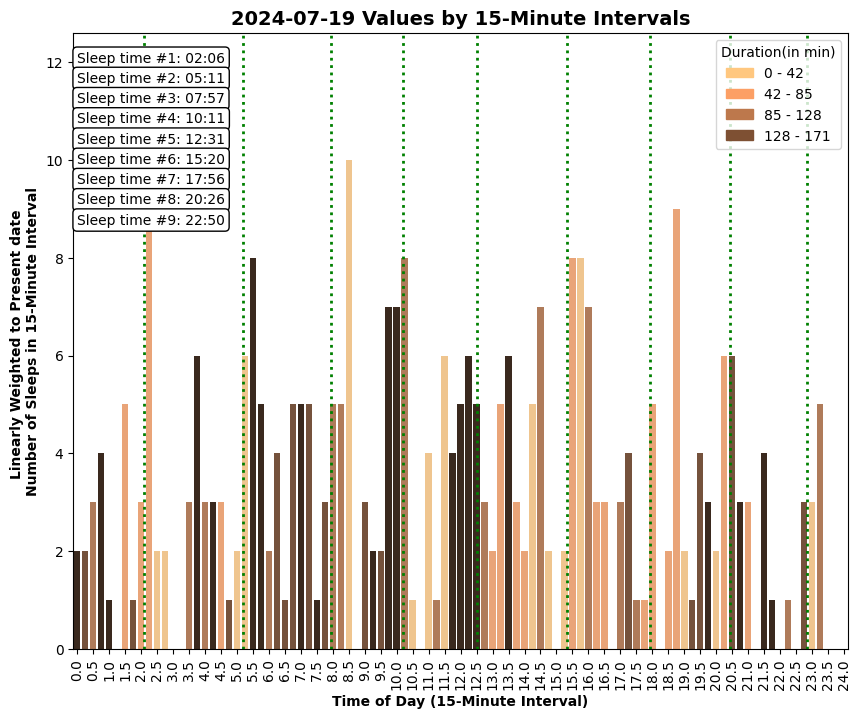

In [ ]:
'''
This next section is to process and weight data so that the most relevent data for clustering is current
'''

#Only Looking at Sleep Measurements
sleep_df = cleaned_df_dld[cleaned_df_dld['measurment'] =='sleep'].reset_index(drop = True)

from sklearn.cluster import MeanShift
import os
import time

class MS_Model_and_Graphs:

    def __init__(self, df, time_col, date, delta_date, linear_weight = True, interval = 15, cmap='copper_r', num_col_cat=5, name = 'Margot'):
        self.time_col = time_col
        self.date = date
        self.delta_date = delta_date
        self.df = df
        self.filter_from_date()
        self.linear_weight = linear_weight
        self.interval = interval
        if self.linear_weight==True:
          self.weight_col()
        else:
          print("No Weighing technique chosen")
        self.intervals_and_format()
        self.timedelta_to_hours_float()
        self.group_and_mean_sum()
        self.dist_col()
        self.fill_dataframe_with_zeros()
        self.time_to_date()
#        self.weight_from_date()
        self.conv_to_seconds_24_hr()
        self.Mean_Shift()
        self.cluster_centers()
        self.cmap = cmap
        self.num_col_cat = num_col_cat
        self.hr_dec_to_HM()
        self.map_data_to_rgb()
        self.order_rgb_tuples_by_luminance()
        self.name = name
        self.create_bar_and_save()



        '''
        df = sleep_df
        time_col = 'Time'
        date = df.iloc[-1]['Time']
        delta_date = 20
        '''

    def filter_from_date(self):

        #This filters out all past dates from designated date with a delta
        for index in self.df.index:
            dif = self.date - self.df.loc[index][self.time_col]
            dif = dif.days
            if dif > self.delta_date:
                self.df = self.df.drop(index)
            else:
                pass
        self.df_copy = self.df.copy()
    def weight_col(self):
    #This creates a weighted column with a distribution of another column
      if self.linear_weight == True:
          self.df.insert(1, 'mult_counter', float(0))
          t = max(self.df[self.time_col]) - min(self.df[self.time_col])
          t = t.days
          for index in self.df.index:
              dif = self.df.loc[index][self.time_col]- min(self.df[self.time_col])
              dif = dif.days
              mul = dif/(t/2)
              self.df.loc[index,'mult_counter'] = mul

      else:
          print("Choose a different weighting technique.")

    def intervals_and_format(self):

      self.df_resampled = self.df.copy()

      # Extract the hour and minute from the index
      self.df_resampled['Hour'] = self.df['Time'].dt.hour
      self.df_resampled['Minute'] = self.df['Time'].dt.minute

      # Create a new index representing the intervals
      self.df_resampled.index = self.df_resampled['Hour'] * (60/self.interval) + self.df_resampled['Minute'] // self.interval

      # Convert the integer values to timedeltas
      self.df_resampled['timedelta'] = pd.to_timedelta(self.df_resampled.index * self.interval * 60, unit='s')


    def timedelta_to_hours_float(self):
    #Create a hours column for the timedelta times in a float (used locally)
      timedelta_hours = []
      for timedelta in self.df_resampled['timedelta']:
        total_seconds = timedelta.total_seconds()
        hours = total_seconds / 3600
        timedelta_hours.append(hours)
      self.df_resampled.insert(1, 'timedelta_hours', timedelta_hours)


    def group_and_mean_sum(self):
      #group the data by the timedelta_hours and create a mean for the Duration in the group but a sum for the rest

      self.df_grouped = self.df_resampled.groupby(by = 'timedelta_hours').sum('mult_counter').reset_index()
      self.df_grouped_mean = self.df_resampled.groupby(by = 'timedelta_hours').mean('mult_counter').reset_index()
      self.df_grouped['Duration(minutes)'] = self.df_grouped_mean['Duration(minutes)']

    def dist_col(self):
      #create a distribution column for the counter weighing
      tot_count = self.df_grouped['mult_counter'].sum()
      self.df_grouped['dist'] = self.df_grouped['mult_counter']/tot_count
      self.df_grouped['dist'] = [int(i*tot_count) for i in self.df_grouped['dist']]


    #Create a list of times in decimal for all 24 hours
    #all_min_list = list(range(0,97,1))
    #all_min_list = [all_min_list[i]/4 for i in all_min_list]

    def add_new_entry(df, column_name, new_value):
      # Create a new row with zeros or NaNs for all columns
      new_row = pd.Series()
      for col in df.columns:
          if col == column_name:
              new_row[col] = new_value

          elif df[col].dtype in [np.int64, np.float64, np.int32]:
              new_row[col] = 0
          else:
              new_row[col] = np.nan
      df = pd.concat([df, new_row.to_frame().T], ignore_index=True)

      return df


    def fill_dataframe_with_zeros(self,column_name = 'timedelta_hours'):
      #Create a list of times in decimal for all 24 hours
      all_min_list = list(range(0,int(1440/self.interval)+1,1))
      unique_list = [all_min_list[i]/(60/self.interval) for i in all_min_list]

      # Create a set of unique values from the column
      unique_values_in_df = set(self.df_grouped[column_name].unique())

      # Find missing values from the unique list
      missing_values = set(unique_list) - unique_values_in_df

      # Fill missing values with zeros
      for value in missing_values:
          self.df_grouped = add_new_entry(self.df_grouped, column_name, value)


      #Resort dataframe and drop indexes
      self.df_grouped = self.df_grouped.sort_values(column_name)
      self.df_grouped = self.df_grouped.reset_index(drop = True)


    def time_to_date(self):
      #date_to_weight_from needs to be the same datatype as list_to_weight datetime items
      #Times List
      self.sleep_times = self.df_copy['Time'].tolist()
      print(self.sleep_times)
      #reordering with most recent timestamp first
      self.sleep_times.reverse()
      #drop the days from the appropriate date
      r = range(len(self.sleep_times))
      sleep_times_temp = []
      for i in r:
          dif = self.sleep_times[0] - self.sleep_times[i]
          dif = dif.days
          if dif < self.delta_date:
            for j in range(dif):
              sleep_times_temp.append(self.sleep_times[i])
              print(j)
          else:
            pass

      self.sleep_times = sleep_times_temp
      self.sleep_times.reverse()

  #    total_dif = list_to_weight[0] - list_to_weight[-1]
  #    total_dif = total_dif.day

    def weight_from_date(self):
      #weight the list by adding and copying items based on the days date
      r = range(len(self.sleep_times))
      temp_list = []
      for i in r:
          num_copies = self.sleep_times[i] - self.sleep_times[-1]
          num_copies = num_copies.days
          for j in list(range(num_copies)):
              self.sleep_times.append(self.sleep_times[i])
      self.sleep_times = sorted(self.sleep_times, reverse=True)


    def conv_to_seconds_24_hr(self):
      #makes my datetimeinto 24 hour seconds with midnight being zero seconds
      for i in range(len(self.sleep_times)):
          hours = self.sleep_times[i].hour
          minutes = self.sleep_times[i].minute
          seconds = self.sleep_times[i].second
          total_seconds = hours * 3600 + minutes * 60 + seconds
          self.sleep_times[i] = total_seconds

    def Mean_Shift(self):
      self.data_MS = np.array(self.sleep_times)
      print(self.data_MS)
      self.ms = MeanShift(bandwidth = 5100).fit(self.data_MS.reshape(-1, 1))
      self.cluster_labels = self.ms.predict(self.data_MS.reshape(-1, 1))

    def cluster_centers(self):
      self.cluster_centers = []
      unique = np.unique(self.cluster_labels)
      for label in np.unique(self.cluster_labels):
          cluster_points = self.data_MS[self.cluster_labels == label]
          cluster_center = np.mean(cluster_points)
          self.cluster_centers.append(cluster_center)
      self.cluster_dec = [round(i/(60*60), 3) for i in self.cluster_centers]
      self.cluster_dec_MS = self.cluster_dec


                    #For relavent graph clusters need to be formated as decimals of hours in a list
    def hr_dec_to_HM(self):
      """Converts a list of seconds to a list of formatted time strings in HH:MM format.

      Args:
          sec_list: A list of seconds.

      Returns:
          A list of formatted time strings.
      """
      sec_list = [int(i*60*60) for i in self.cluster_dec_MS]
      # Convert seconds to UTC datetime objects
      cluster_times = [datetime.datetime.fromtimestamp(seconds, pytz.UTC) for seconds in sec_list]

      # Extract time strings in HH:MM:SS format
      time_strings = [dt.strftime('%H:%M:%S') for dt in cluster_times]

      # Remove seconds
      self.cluster_time_strings = [time_string[:5] for time_string in time_strings]

      #sort
      self.cluster_time_strings.sort()


    def map_data_to_rgb(self):
      # Normalize values to a 0-1 range
      normalized_values = (self.df_grouped['Duration(minutes)'] - np.min(self.df_grouped['Duration(minutes)'])) / (np.max(self.df_grouped['Duration(minutes)']) - np.min(self.df_grouped['Duration(minutes)']))

      # Calculate the interval size for categorization
      interval_size = 1.0 / self.num_col_cat

      # Categorize the data
      categorized_data = [(int(value // interval_size) / self.num_col_cat) for value in normalized_values]

      # Create a colormap object
      cmap = mpl.colormaps[self.cmap]  # Use recommended usage

      # Map values to RGB colors
      self.rgb_colors = [cmap(value) for value in categorized_data]

      #get catagorized intervals
      self.categorized_interval = []
      data_interval = np.max(self.df_grouped['Duration(minutes)']) - np.min(self.df_grouped['Duration(minutes)'])
      for i in range(1,(self.num_col_cat),1):
          self.categorized_interval.append(f'{int(interval_size*(i-1)*data_interval)} - {int(interval_size*i*data_interval)}')


    def order_rgb_tuples_by_luminance(self):
      """Orders a list of RGB tuples with alpha values from light to dark.

      Args:
          rgb_tuples: A list of RGB tuples, each containing 4 elements: red, green, blue, and alpha.

      Returns:
          A new list of RGB tuples ordered by luminance.
      """
      self.rgb_colors = list(set(self.rgb_colors))

      # Calculate the luminance for each RGB tuple
      luminances = [np.dot(rgb_tuple[:3], [0.2126, 0.7152, 0.0722]) * rgb_tuple[3] for rgb_tuple in self.rgb_colors]

      # Create a list of tuples containing the RGB tuple and its luminance
      tuples_with_luminance = list(zip(self.rgb_colors, luminances))

      # Sort the tuples by luminance in descending order
      sorted_tuples = sorted(tuples_with_luminance, key=lambda x: x[1], reverse=True)

      # Extract the original RGB tuples from the sorted tuples
      self.unique_colors = [rgb_tuple for rgb_tuple, _ in sorted_tuples]


    def create_bar_and_save(self):
      plt.clf()
      x = self.df_grouped['timedelta_hours']
      y = self.df_grouped['dist']
      fig, ax = plt.subplots(figsize=(10, 8))
                                              #Create the plot
      palette = sns.color_palette(self.rgb_colors)

      # Use the palette in a Seaborn plot
      sns.barplot(x='timedelta_hours', y='dist', hue = 'Duration(minutes)', data=self.df_grouped, palette=palette, ax = ax, legend = True)
      handles = [plt.Rectangle((0, 0), 1, 1, color=rgb) for rgb in self.unique_colors]
      legend = plt.legend(handles, self.categorized_interval, title="Duration(in min)", loc = 'upper right')

                      #Create verticle prediction lines

      #cluster_alt_MS = [i*4 for i in self.cluster_dec_MS]
      cluster_alt_MS = self.cluster_dec_MS

      vertical_line_positions_MS = pd.Series(cluster_alt_MS, index = range(len(cluster_alt_MS)))
      vertical_line_positions_MS.name = 'timedelta_hours'
      vertical_line_positions_MS = vertical_line_positions_MS.round(decimals=2)
      #Add Vertical Lines
      for i in list(vertical_line_positions_MS):
        i = round(i, 2)
        plt.axvline(x=(i*(60/self.interval)), color='green', linestyle=':', linewidth=2)



      # Get the maximum value in 'dist' column
      max_dist = max(y)


      #Set axis titles
      ax.set_xlabel(f'Time of Day ({self.interval}-Minute Interval)', fontsize=10, fontweight='bold', fontfamily='sans-serif', color='black')
      ax.set_ylabel(f'Linearly Weighted to Present date \nNumber of Sleeps in {self.interval}-Minute Interval', fontsize=10, fontweight='bold', fontfamily='sans-serif', color='black')
      ax.set_title(f'{self.date.strftime("%Y-%m-%d")} Values by {self.interval}-Minute Intervals', fontsize=14, fontweight='bold', fontfamily='sans-serif', color='black')
      x_ticks = [round(float(i/(60/self.interval)), 2) for i in list(range(0, 24*self.interval, 1))]
      xticks = plt.gca().get_xticks()
      xticklabels = plt.gca().get_xticklabels()
      plt.xticks(xticks[::2], xticklabels[::2], rotation = 90)
#      ax.set_xticklabels(x_ticks, rotation=90, ha="center")
      #ax.set_xticks(list(range(0, 96, 4)), rotation=90)


      # Create a list of floats from 0 to 10 with 100 steps
      y_labels = np.linspace(0, max_dist, 30)

      # Make array to list (assuming you need it)
      y_labels = y_labels.tolist()

      # Reverse list if necessary (adjust based on your needs)
      y_labels.reverse()

      for i, j in zip(y_labels, self.cluster_time_strings):
          i_print = y_labels.index(i) + 1
          ax.text(0, i, f'Sleep time #{i_print}: {j}', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))


      if  self.date == self.df.iloc[-1]['Time']:
        # Show the plot
        plt.show()
      else:
        pass

      current_directory = os.getcwd()
      parent_dir = os.path.dirname(current_directory)
      print(f"Saved to {parent_dir}")

      # Save the plot with axes
      fig.savefig(os.path.join(f'{parent_dir}/content/{self.name}', f"{self.date}.png"), dpi=300)


# Create the new folder
# Create the new folder if it doesn't already exist
current_directory = os.getcwd()
parent_dir = os.path.dirname(current_directory)
days_for_animation = 20



if not os.path.exists(os.path.join(f'{parent_dir}/content', name)):
  os.makedirs(os.path.join(f'{parent_dir}/content', name))
  for i in range(days_for_animation):
    date = sleep_df.iloc[-1]['Time']
    day_number = date.date().toordinal()
    day_number -= i
    date = datetime.date.fromordinal(day_number)
    # Create a time object representing noon
    noon_time = datetime.time(12, 0)
    # Combine the date and time to create a datetime object
    datetime_object = datetime.datetime.combine(date, noon_time)
    print(datetime_object)
    instance = MS_Model_and_Graphs(df = sleep_df, time_col = 'Time', date = datetime_object, delta_date = 20, linear_weight = True, interval = 15, cmap='copper_r', name = name)

else:
  timestamp = int(time.time())
  new_folder_name_unique = f"{name}_{timestamp}"
  os.makedirs(os.path.join(f'{parent_dir}/content', new_folder_name_unique))
  for i in range(days_for_animation):
    date = sleep_df.iloc[-1]['Time']
    day_number = date.date().toordinal()
    day_number -= i
    date = datetime.date.fromordinal(day_number)
    # Create a time object representing noon
    noon_time = datetime.time(12, 0)
    # Combine the date and time to create a datetime object
    datetime_object = datetime.datetime.combine(date, noon_time)
    print(datetime_object)
    instance = MS_Model_and_Graphs(df = sleep_df, time_col = 'Time', date = datetime_object, delta_date = 20, linear_weight = True, interval = 15, cmap='copper_r', name = new_folder_name_unique)







'''
class Create_Mult_Graphs_and_Save:
  def __init__(self):


class Animate_Graphs:
  def __init__(self):

  def

'''









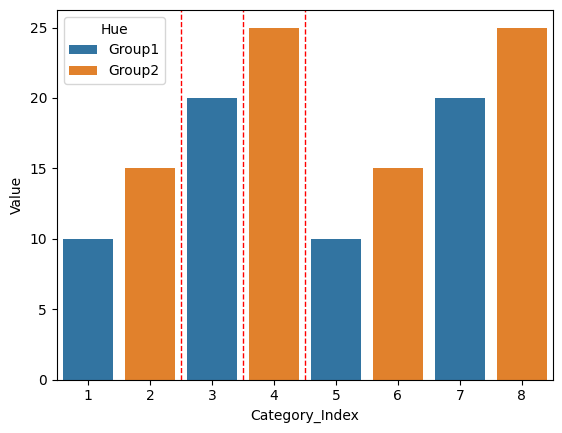

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd

# Sample data with a categorical variable for 'hue'
data = {
    'Category': ['A', 'B', 'C', 'D'] * 2,
    'Value': [10, 15, 20, 25] * 2,
    'Hue': ['Group1', 'Group2'] * 4
}
df = pd.DataFrame(data)

# Convert the 'Category' column to a numerical index
df['Category_Index'] = df.index + 1

# Create the bar plot using the numerical index
sns.barplot(x='Category_Index', y='Value', hue='Hue', data=df)

# Define the positions for the vertical lines based on the category indices
line_positions = [1.5, 2.5, 3.5]

# Add the vertical lines
for pos in line_positions:
    plt.axvline(x=pos, color='red', linestyle='--', linewidth=1)

plt.show()



In [ ]:
'''
This next section is to process and weight data so that the most relevent data for clustering is current
'''

#Only Looking at Sleep Measurements
sleep_df = cleaned_df_dld[cleaned_df_dld['measurment'] =='sleep'].reset_index(drop = True)


class MS_Model_and_Graphs:
    def __init__(self, df, time_col, date, delta_date):
        self.time_col = time_col
        self.date = date
        self.delta_date = delta_date
        self.df = df
        self.filter_from_date()

        '''
        df = sleep_df
        time_col = 'Time'
        date = df.iloc[-1]['Time']
        delta_date = 20
        '''

    def filter_from_date(self.df, self.time_col, self.date, self.delta_date):

        #This filters out all past dates from designated date with a delta
        for index in self.df.index:
            dif = self.date - self.df.loc[index][self.time_col]
            dif = dif.days
            if dif > self.delta_date:
                self.df = self.df.drop(index)
            else:
                pass


    filter_from_date(df, time_col, date, 20)

#Only looking at dates from now to a certain time period 20 days in the past

def filter_from_date(df, time_col, date, delta_date):

    #This filters out all past dates from designated date with a delta

    for index in df.index:
        dif = date - df.loc[index][time_col]
        dif = dif.days
        if dif > delta_date:
            df = df.drop(index)
        else:
            pass

date = sleep_df.iloc[-1]['Time']
filter_from_date(sleep_df, 'Time', date, 20)


#Make a special algorythm that weights the first date delta_days times more than the date 20 days ago
#by replicating the points
def weight_col(df, col, linear_weight=True):
    #This creates a weighted column with a distribution of another column
    if linear_weight == True:
        df.insert(1, 'mult_counter', float(0))
        t = max(df[col]) - min(df[col])
        t = t.days
        for index in df.index:
            dif = df.loc[index][col]- min(df[col])
            dif = dif.days
            mul = dif/(t/2)
            df.loc[index,'mult_counter'] = mul

    else:
        print("Choose a different weighting technique.")

    return df

sleep_df = weight_col(sleep_df, 'Time')

sleep_df.head()



df_resampled = sleep_df.copy()

# Extract the hour and minute from the index
df_resampled['Hour'] = sleep_df['Time'].dt.hour
df_resampled['Minute'] = sleep_df['Time'].dt.minute

# Create a new index representing the 15-minute intervals
df_resampled.index = df_resampled['Hour'] * 4 + df_resampled['Minute'] // 15

# Convert the integer values to timedeltas
df_resampled['timedelta'] = pd.to_timedelta(df_resampled.index * 15 * 60, unit='s')# 15 minutes = 15 * 60 seconds

#Create a hours column for the timedelta times in a float
def timedelta_to_hours_float(timedelta):
    total_seconds = timedelta.total_seconds()
    hours = total_seconds / 3600
    return hours

df_resampled.insert(1, 'timedelta_hours', df_resampled['timedelta'].apply(timedelta_to_hours_float))


#group the data by the timedelta_hours and create a mean for the Duration in the group but a sum for the rest

df_grouped = df_resampled.groupby(by = 'timedelta_hours').sum('mult_counter').reset_index()
df_grouped_mean = df_resampled.groupby(by = 'timedelta_hours').mean('mult_counter').reset_index()
df_grouped['Duration(minutes)'] = df_grouped_mean['Duration(minutes)']

#create a distribution column for the counter weighing
tot_count = df_grouped['mult_counter'].sum()
df_grouped['dist'] = df_grouped['mult_counter']/tot_count

df_grouped['dist'] = [int(i*tot_count) for i in df_grouped['dist']]


#Create a list of times in decimal for all 24 hours
all_min_list = list(range(0,97,1))
all_min_list = [all_min_list[i]/4 for i in all_min_list]



def add_new_entry(df, column_name, new_value):
    # Create a new row with zeros or NaNs for all columns
    new_row = pd.Series()
    for col in df.columns:
        if col == column_name:
            new_row[col] = new_value
        elif df[col].dtype in [np.int64, np.float64, np.int32]:
            new_row[col] = 0
        else:
            new_row[col] = np.nan
    df = pd.concat([df, new_row.to_frame().T], ignore_index=True)

    return df


def fill_dataframe_with_zeros(df, column_name, unique_list):

    # Create a set of unique values from the column
    unique_values_in_df = set(df[column_name].unique())

    # Find missing values from the unique list
    missing_values = set(unique_list) - unique_values_in_df


    # Fill missing values with zeros
    for value in missing_values:
        df = add_new_entry(df, column_name, value)


    df = df.sort_values(column_name)
    return df

#df_grouped.info()
df_grouped = fill_dataframe_with_zeros(df_grouped, 'timedelta_hours', all_min_list)

df_grouped = df_grouped.reset_index(drop = True)


#import datetime


#Take and make the time series sleep times into a clustering model problem.

#Create a 1D list weighte with more points toward recent.  If its 30 days, 30 items on present day 29 items on the next day...

#Create Copy

cleaned_df_dld_2 = csvs_combined_new_par.copy()
df_sleep_copy = cleaned_df_dld_2[cleaned_df_dld_2['measurment'] =='sleep'].reset_index(drop = True)



#Times List
sleep_times = df_sleep_copy['Time'].tolist()

#reordering with most recent timestamp first
sleep_times.reverse()

def time_to_date(list_of_data, date_to_weight_from, delta_time):
    #date_to_weight_from needs to be the same datatype as list_to_weight datetime items

    #drop the days from the appropriate date
    r = range(len(list_of_data))
    del_index = []
    for i in r:
        dif = date_to_weight_from - list_of_data[i]
        dif = dif.days
        if dif < delta_time:
            pass

        else:
            del_index.append(i)

    for index in sorted(del_index, reverse=True):
        del list_of_data[index]
    return list_of_data

#    total_dif = list_to_weight[0] - list_to_weight[-1]
#    total_dif = total_dif.day

def weight_from_date(list_to_weight):
    #weight the list by adding and copying items based on the days date
    r = range(len(list_to_weight))
    temp_list = []
    for i in r:
        num_copies = list_to_weight[i] - list_to_weight[-1]
        num_copies = num_copies.days
        for j in list(range(num_copies)):
            list_to_weight.append(list_to_weight[i])
    list_to_weight = sorted(list_to_weight, reverse=True)
    return list_to_weight



def conv_to_seconds_24_hr(data):
    #makes my datetimeinto 24 hour seconds with midnight being zero seconds
    for i in range(len(data)):
        hours = data[i].hour
        minutes = data[i].minute
        seconds = data[i].second
        total_seconds = hours * 3600 + minutes * 60 + seconds
        data[i] = total_seconds
    return data

sleep_times = time_to_date(sleep_times, sleep_times[0], 20)


sleep_times = weight_from_date(sleep_times)


sleep_times = conv_to_seconds_24_hr(sleep_times)


#initiate data in seconds
timestamps_sec = sleep_times
data = np.array(timestamps_sec)

MS = True

if MS == False:
  print('Mean_Shift ran')
else:

  from sklearn.cluster import MeanShift

    # Create sample data
  #  data = np.random.rand(100, 2)  # Assuming 2-dimensional data
  # Create sample 1D data
  data_MS = np.array(data)

  # Fit the Mean Shift model to the data
  ms = MeanShift(bandwidth = 5100).fit(data_MS.reshape(-1, 1))

  # Get the cluster assignments for each data point
  cluster_labels = ms.predict(data.reshape(-1, 1))



  def cluster_centers(labels):
    cluster_centers = []
    unique = np.unique(labels)
    for label in np.unique(labels):
        cluster_points = data[labels == label]
        cluster_center = np.mean(cluster_points)
        cluster_centers.append(cluster_center)
    cluster_decimals = [round(i/(60*60), 3) for i in cluster_centers]
    return cluster_centers,cluster_decimals

  cluster_centers_index, cluster_dec = cluster_centers(cluster_labels)
  cluster_dec_MS = cluster_dec


                    #For relavent graph clusters need to be formated as decimals of hours in a list
def hr_dec_to_HM(min_list):
    """Converts a list of seconds to a list of formatted time strings in HH:MM format.

    Args:
        sec_list: A list of seconds.

    Returns:
        A list of formatted time strings.
    """
    sec_list = [int(i*60*60) for i in min_list]
    # Convert seconds to UTC datetime objects
    cluster_times = [datetime.datetime.fromtimestamp(seconds, pytz.UTC) for seconds in sec_list]

    # Extract time strings in HH:MM:SS format
    time_strings = [dt.strftime('%H:%M:%S') for dt in cluster_times]

    # Remove seconds
    formatted_time_strings = [time_string[:5] for time_string in time_strings]

    return formatted_time_strings


clusters_time_strings = hr_dec_to_HM(cluster_dec_MS)#Best Model



                    #Clear plot and define x and y
plt.clf()

x = df_grouped['timedelta_hours']

y = df_grouped['dist']

# Create a figure with axes
fig, ax = plt.subplots(figsize=(10, 8))




                            # Map data do a rgb cmap and then take the data create a rgb unique series for the data on the cmap
def map_data_to_rgb(values, cmap='viridis', num_categories=5):
    # Normalize values to a 0-1 range
    normalized_values = (values - np.min(values)) / (np.max(values) - np.min(values))

    # Calculate the interval size for categorization
    interval_size = 1.0 / num_categories

    # Categorize the data
    categorized_data = [(int(value // interval_size) / num_categories) for value in normalized_values]

    # Create a colormap object
    cmap = mpl.colormaps[cmap]  # Use recommended usage

    # Map values to RGB colors
    rgb_colors = [cmap(value) for value in categorized_data]

    #get catagorized intervals
    categorized_interval = []
    data_interval = np.max(values) - np.min(values)
    for i in range(1,(num_categories),1):
        categorized_interval.append(f'{int(interval_size*(i-1)*data_interval)} - {int(interval_size*i*data_interval)}')

    return rgb_colors, categorized_interval

def order_rgb_tuples_by_luminance(rgb_tuples):
    """Orders a list of RGB tuples with alpha values from light to dark.

    Args:
        rgb_tuples: A list of RGB tuples, each containing 4 elements: red, green, blue, and alpha.

    Returns:
        A new list of RGB tuples ordered by luminance.
    """

    # Calculate the luminance for each RGB tuple
    luminances = [np.dot(rgb_tuple[:3], [0.2126, 0.7152, 0.0722]) * rgb_tuple[3] for rgb_tuple in rgb_tuples]

    # Create a list of tuples containing the RGB tuple and its luminance
    tuples_with_luminance = list(zip(rgb_tuples, luminances))

    # Sort the tuples by luminance in descending order
    sorted_tuples = sorted(tuples_with_luminance, key=lambda x: x[1], reverse=True)

    # Extract the original RGB tuples from the sorted tuples
    ordered_rgb_tuples = [rgb_tuple for rgb_tuple, _ in sorted_tuples]

    return ordered_rgb_tuples

#Create the ordered tuples by luminocity
rgb_colors, categorized_interval  = map_data_to_rgb(df_grouped['Duration(minutes)'], cmap='copper_r')
unique_colors = order_rgb_tuples_by_luminance(list(set(rgb_colors)))



                                        #Create the plot
palette = sns.color_palette(rgb_colors)

print(palette)

# Use the palette in a Seaborn plot
sns.barplot(x='timedelta_hours', y='dist', hue = 'Duration(minutes)', data=df_grouped, palette=palette, ax = ax, legend = True)

#Create a custome legend
def custom_legend_formatting(colors,values):
    text_objects = []
    # Create individual Text objects and append them to the list
    for v in values:
        text = plt.text(0, 0, f"Text {v}")  # Adjust position and text as needed]
        text_objects.append(text)
    for color, value in zip(colors, text_objects):
        color = color[:3]
        value.set_text(f"{value}")  # Remove HTML formatting
        value.set_color(color)
        return text_objects

handles = [plt.Rectangle((0, 0), 1, 1, color=rgb) for rgb in unique_colors]
legend = plt.legend(handles,categorized_interval, title="Duration(in min)", loc = 'upper right')

                #Create verticle prediction lines
'''
cluster_alt_DBSCAN = [i*4 for i in cluster_dec_DBSCAN]
vertical_line_positions_DBSCAN = pd.Series({'timedelta_hours': cluster_alt_DBSCAN})

cluster_alt_GMM = [i*4 for i in cluster_dec_GMM]
vertical_line_positions_GMM = pd.Series({'timedelta_hours': cluster_alt_GMM})

cluster_alt_HA = [i*4 for i in cluster_dec_HA]
vertical_line_positions_HA = pd.Series({'timedelta_hours': cluster_alt_HA})
'''

cluster_alt_MS = [i*4 for i in cluster_dec_MS]
vertical_line_positions_MS = pd.Series({'timedelta_hours': cluster_alt_MS})
'''

cluster_alt_AP = [i*4 for i in cluster_dec_AP]
vertical_line_positions_AP = pd.Series({'timedelta_hours': cluster_alt_AP})
'''

# Get the maximum value in 'dist' column
max_dist = max(y)


#Set axis titles
ax.set_xlabel('Time of Day (15-Minute Interval)', fontsize=10, fontweight='bold', fontfamily='sans-serif', color='black')
ax.set_ylabel('Linearly Weighted to Present date \nNumber of Sleeps in 15-Minute Interval', fontsize=10, fontweight='bold', fontfamily='sans-serif', color='black')
ax.set_title('Bar Chart of Values by 15-Minute Intervals', fontsize=14, fontweight='bold', fontfamily='sans-serif', color='black')
ax.set_xticks(list(range(0, 96, 4)))

#Add Vertical Lines
'''

for i in vertical_line_positions_DBSCAN['timedelta_hours']:
    ax.axvline(x=i, color='red', linestyle=':', linewidth=2)

for i in vertical_line_positions_GMM['timedelta_hours']:
    ax.axvline(x=i, color='blue', linestyle='--', linewidth=2)

for i in vertical_line_positions_HA['timedelta_hours']:
    ax.axvline(x=i, color='orange', linestyle=':', linewidth=2)
'''
for i in vertical_line_positions_MS['timedelta_hours']:
    ax.axvline(x=i, color='green', linestyle=':', linewidth=2)


# Create a list of floats from 0 to 10 with 100 steps
y_labels = np.linspace(0, max_dist, 30)

# Make array to list (assuming you need it)
y_labels = y_labels.tolist()

# Reverse list if necessary (adjust based on your needs)
y_labels.reverse()

for i, j in zip(y_labels, clusters_time_strings):
    i_print = y_labels.index(i) + 1
    ax.text(0, i, f'Sleep time #{i_print}: {j}', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))



# Show the plot
plt.show()

DBSCAN_Run = False
GMM = False
Aglomerative_Hierarchy = False
MS = True
AP = False

if DBSCAN_Run == True:
  cluster_dec_DBSCAN.sort()
  print("DBSCAN Clusters:", cluster_dec_DBSCAN)
else:
  print('why')
  pass
if GMM == True:
  cluster_dec_GMM.sort()
  print("GMM Clusters:", cluster_dec_GMM)
else:
  pass
if Aglomerative_Hierarchy == True:
  cluster_dec_HA.sort()
  print("Hierarchial Clusters:", cluster_dec_HA)
else:
  pass
if MS == True:
  cluster_dec_MS.sort()
  print("MS Clusters:", cluster_dec_MS)
else:
  pass
if AP == True:
  cluster_dec_AP.sort()
  print("AP Clusters:", cluster_dec_AP)
else:
  pass


import os

current_directory = os.getcwd()
parent_dir = os.path.dirname(current_directory)
print(f"Saved to {parent_dir}")

# Save the plot with axes
fig.savefig(os.path.join(parent_dir, "my_plot.png"), dpi=300)



SyntaxError: invalid syntax (<ipython-input-8-1e788766c71f>, line 24)

In [ ]:

#initiate data in seconds
timestamps_sec = sleep_times
data = np.array(timestamps_sec)

MS = True

if MS == False:
  print('Mean_Shift ran')
else:

  from sklearn.cluster import MeanShift

    # Create sample data
  #  data = np.random.rand(100, 2)  # Assuming 2-dimensional data
  # Create sample 1D data
  data_MS = np.array(data)

  # Fit the Mean Shift model to the data
  ms = MeanShift(bandwidth = 5100).fit(data_MS.reshape(-1, 1))

  # Get the cluster assignments for each data point
  cluster_labels = ms.predict(data.reshape(-1, 1))



  def cluster_centers(labels):
    cluster_centers = []
    unique = np.unique(labels)
    for label in np.unique(labels):
        cluster_points = data[labels == label]
        cluster_center = np.mean(cluster_points)
        cluster_centers.append(cluster_center)
    cluster_decimals = [round(i/(60*60), 3) for i in cluster_centers]
    return cluster_centers,cluster_decimals

  cluster_centers_index, cluster_dec = cluster_centers(cluster_labels)
  cluster_dec_MS = cluster_dec


                    #For relavent graph clusters need to be formated as decimals of hours in a list
def hr_dec_to_HM(min_list):
    """Converts a list of seconds to a list of formatted time strings in HH:MM format.

    Args:
        sec_list: A list of seconds.

    Returns:
        A list of formatted time strings.
    """
    sec_list = [int(i*60*60) for i in min_list]
    # Convert seconds to UTC datetime objects
    cluster_times = [datetime.datetime.fromtimestamp(seconds, pytz.UTC) for seconds in sec_list]

    # Extract time strings in HH:MM:SS format
    time_strings = [dt.strftime('%H:%M:%S') for dt in cluster_times]

    # Remove seconds
    formatted_time_strings = [time_string[:5] for time_string in time_strings]

    return formatted_time_strings


clusters_time_strings = hr_dec_to_HM(cluster_dec_MS)#Best Model



                    #Clear plot and define x and y
plt.clf()

x = df_grouped['timedelta_hours']

y = df_grouped['dist']

# Create a figure with axes
fig, ax = plt.subplots(figsize=(10, 8))




                            # Map data do a rgb cmap and then take the data create a rgb unique series for the data on the cmap
def map_data_to_rgb(values, cmap='viridis', num_categories=5):
    # Normalize values to a 0-1 range
    normalized_values = (values - np.min(values)) / (np.max(values) - np.min(values))

    # Calculate the interval size for categorization
    interval_size = 1.0 / num_categories

    # Categorize the data
    categorized_data = [(int(value // interval_size) / num_categories) for value in normalized_values]

    # Create a colormap object
    cmap = mpl.colormaps[cmap]  # Use recommended usage

    # Map values to RGB colors
    rgb_colors = [cmap(value) for value in categorized_data]

    #get catagorized intervals
    categorized_interval = []
    data_interval = np.max(values) - np.min(values)
    for i in range(1,(num_categories),1):
        categorized_interval.append(f'{int(interval_size*(i-1)*data_interval)} - {int(interval_size*i*data_interval)}')

    return rgb_colors, categorized_interval

def order_rgb_tuples_by_luminance(rgb_tuples):
    """Orders a list of RGB tuples with alpha values from light to dark.

    Args:
        rgb_tuples: A list of RGB tuples, each containing 4 elements: red, green, blue, and alpha.

    Returns:
        A new list of RGB tuples ordered by luminance.
    """

    # Calculate the luminance for each RGB tuple
    luminances = [np.dot(rgb_tuple[:3], [0.2126, 0.7152, 0.0722]) * rgb_tuple[3] for rgb_tuple in rgb_tuples]

    # Create a list of tuples containing the RGB tuple and its luminance
    tuples_with_luminance = list(zip(rgb_tuples, luminances))

    # Sort the tuples by luminance in descending order
    sorted_tuples = sorted(tuples_with_luminance, key=lambda x: x[1], reverse=True)

    # Extract the original RGB tuples from the sorted tuples
    ordered_rgb_tuples = [rgb_tuple for rgb_tuple, _ in sorted_tuples]

    return ordered_rgb_tuples

#Create the ordered tuples by luminocity
rgb_colors, categorized_interval  = map_data_to_rgb(df_grouped['Duration(minutes)'], cmap='copper_r')
unique_colors = order_rgb_tuples_by_luminance(list(set(rgb_colors)))



                                        #Create the plot
palette = sns.color_palette(rgb_colors)

# Use the palette in a Seaborn plot
sns.barplot(x='timedelta_hours', y='dist', hue = 'Duration(minutes)', data=df_grouped, palette=palette, ax = ax, legend = True)

#Create a custome legend
def custom_legend_formatting(colors,values):
    text_objects = []
    # Create individual Text objects and append them to the list
    for v in values:
        text = plt.text(0, 0, f"Text {v}")  # Adjust position and text as needed]
        text_objects.append(text)
    for color, value in zip(colors, text_objects):
        color = color[:3]
        value.set_text(f"{value}")  # Remove HTML formatting
        value.set_color(color)
        return text_objects

handles = [plt.Rectangle((0, 0), 1, 1, color=rgb) for rgb in unique_colors]
legend = plt.legend(handles,categorized_interval, title="Duration(in min)", loc = 'upper right')

                #Create verticle prediction lines
'''
cluster_alt_DBSCAN = [i*4 for i in cluster_dec_DBSCAN]
vertical_line_positions_DBSCAN = pd.Series({'timedelta_hours': cluster_alt_DBSCAN})

cluster_alt_GMM = [i*4 for i in cluster_dec_GMM]
vertical_line_positions_GMM = pd.Series({'timedelta_hours': cluster_alt_GMM})

cluster_alt_HA = [i*4 for i in cluster_dec_HA]
vertical_line_positions_HA = pd.Series({'timedelta_hours': cluster_alt_HA})
'''

cluster_alt_MS = [i*4 for i in cluster_dec_MS]
vertical_line_positions_MS = pd.Series({'timedelta_hours': cluster_alt_MS})
'''

cluster_alt_AP = [i*4 for i in cluster_dec_AP]
vertical_line_positions_AP = pd.Series({'timedelta_hours': cluster_alt_AP})
'''

# Get the maximum value in 'dist' column
max_dist = max(y)


#Set axis titles
ax.set_xlabel('Time of Day (15-Minute Interval)', fontsize=10, fontweight='bold', fontfamily='sans-serif', color='black')
ax.set_ylabel('Linearly Weighted to Present date \nNumber of Sleeps in 15-Minute Interval', fontsize=10, fontweight='bold', fontfamily='sans-serif', color='black')
ax.set_title('Bar Chart of Values by 15-Minute Intervals', fontsize=14, fontweight='bold', fontfamily='sans-serif', color='black')
ax.set_xticks(list(range(0, 96, 4)))

#Add Vertical Lines
'''

for i in vertical_line_positions_DBSCAN['timedelta_hours']:
    ax.axvline(x=i, color='red', linestyle=':', linewidth=2)

for i in vertical_line_positions_GMM['timedelta_hours']:
    ax.axvline(x=i, color='blue', linestyle='--', linewidth=2)

for i in vertical_line_positions_HA['timedelta_hours']:
    ax.axvline(x=i, color='orange', linestyle=':', linewidth=2)
'''
for i in vertical_line_positions_MS['timedelta_hours']:
    ax.axvline(x=i, color='green', linestyle=':', linewidth=2)


# Create a list of floats from 0 to 10 with 100 steps
y_labels = np.linspace(0, max_dist, 30)

# Make array to list (assuming you need it)
y_labels = y_labels.tolist()

# Reverse list if necessary (adjust based on your needs)
y_labels.reverse()

for i, j in zip(y_labels, clusters_time_strings):
    i_print = y_labels.index(i) + 1
    ax.text(0, i, f'Sleep time #{i_print}: {j}', bbox=dict(facecolor='white', edgecolor='black', boxstyle='round'))



# Show the plot
plt.show()

DBSCAN_Run = False
GMM = False
Aglomerative_Hierarchy = False
MS = True
AP = False

if DBSCAN_Run == True:
  cluster_dec_DBSCAN.sort()
  print("DBSCAN Clusters:", cluster_dec_DBSCAN)
else:
  print('why')
  pass
if GMM == True:
  cluster_dec_GMM.sort()
  print("GMM Clusters:", cluster_dec_GMM)
else:
  pass
if Aglomerative_Hierarchy == True:
  cluster_dec_HA.sort()
  print("Hierarchial Clusters:", cluster_dec_HA)
else:
  pass
if MS == True:
  cluster_dec_MS.sort()
  print("MS Clusters:", cluster_dec_MS)
else:
  pass
if AP == True:
  cluster_dec_AP.sort()
  print("AP Clusters:", cluster_dec_AP)
else:
  pass


import os

current_directory = os.getcwd()
parent_dir = os.path.dirname(current_directory)
print(f"Saved to {parent_dir}")

# Save the plot with axes
fig.savefig(os.path.join(parent_dir, "my_plot.png"), dpi=300)

